## Task 1.1 – Logistic Regression task
1.1.1 Describe the dataset (e.g., descriptive statistics, missing values, target rate).

1.1.2 Describe the feature engineering procedure and the data treatments you followed (if any).

1.1.3 Describe the model selection process you applied (e.g., criteria for feature selection, estimation technique of the model parameters).

1.1.4 Explain the final model in terms of statistical results and business interpretation of regression coefficients.

1.1.5 Present the assumptions of the logistic regression and check if they are fulfilled by your model.

1.1.6 Calculate the following performance metrics: Accuracy, Precision, Recall and F1 score both in Testing and Training samples.

1.1.7 Create the ROC curve (AUC) and explain the discriminatory power of the model both in Testing and Training samples.



### Importing libraries 

In [1]:
from datetime import datetime
import calendar
import random
import time
from time import perf_counter, sleep
from functools import wraps
from typing import Callable, Any
import warnings
from tqdm import tqdm

import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, KFold
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.utils import resample
from sklearn.utils.class_weight import compute_class_weight

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, balanced_accuracy_score, f1_score, confusion_matrix, classification_report, roc_curve, auc, roc_auc_score
from sklearn.pipeline import make_pipeline
from sklearn.cross_decomposition import PLSRegression
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor
from scipy.stats import chi2_contingency
from sklearn.metrics import ConfusionMatrixDisplay
from scipy.stats import mode

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import balanced_accuracy_score, accuracy_score
import optuna
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split
from sklearn.metrics import balanced_accuracy_score, accuracy_score
import optuna
import shap
from xgboost import XGBClassifier

import warnings

warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=pd.errors.SettingWithCopyWarning)


In [2]:
# set random seeds for reproducibility
seed = 1234
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)

## Let's load the dataset

In [3]:
description = pd.read_excel('https://challengerocket.com/files/lions-den-ing-2024/variables_description.xlsx', header=0)
train = pd.read_csv('https://files.challengerocket.com/files/lions-den-ing-2024/development_sample.csv')


## 1.1.1 Describe the dataset

In [4]:
print(train.shape)
print(train[train['Application_status']=='Rejected'].shape[0]/train.shape[0])


(50000, 36)
0.26564


The train dataset is build upon 50 000 records an 36 columns. Test dataset consist of 5000 records. The number of rejected applications (that need to be removed) makes around 26% of the train dataset. For the further clarity of the analysis, let's drop rejected applications. 

In [5]:
df = train[train['Application_status']=='Approved']

In [6]:
df['target'].value_counts(normalize=True)

target
0.0    0.969307
1.0    0.030693
Name: proportion, dtype: float64

Loans that went into default make only 3% of total applications (in this dataset). Which makes it very unbalanced. Which would be addressed in the further analysis with diffrent methods for diffrent models.

To process further we need to divide features into categorical and numerical. The division is based on the close analysis of column descriptions and values. Additionaly we catched columns that won't be taken into account by our model. Furthermore Var13 - date of employment is transformed into the number of days between employment and application_date. 

In [7]:
not_features = ['ID','customer_id', 'application_date', 'Application_status', 'Var13', '_r_']

target = 'target'

categorical_features = ['Var2', 'Var3', 'Var11','Var12', 'Var14','Var18', 'Var19']

binary_features = ['Var27', 'Var28']

days_from_employment = 'Var13_b'

numerical_features = ['Var1', 'Var4', 'Var5', 'Var6', 'Var7', 'Var8', 'Var9', 'Var10', 'Var15', 'Var16', 'Var17', 'Var20', 'Var21', 'Var22', 'Var23', 'Var24', 'Var25', 'Var26', 'Var29', 'Var30', days_from_employment]



### Get days from employment 

In [8]:
d1 = pd.to_datetime(df['application_date'].copy(), format='%d%b%Y %H:%M:%S', errors='coerce')
d2 = pd.to_datetime(df['Var13'], format='%d%b%Y', errors='coerce')
df[days_from_employment] = (d1 - d2).dt.days

## Descriptive analysis

### Descirption of numerical values

Description of numerical values can be done quickly by pandas built-in function descirbe() 

In [9]:
df[numerical_features].describe()

,Var1,Var4,Var5,Var6,Var7,Var8,Var9,Var10,Var15,Var16,...,Var20,Var21,Var22,Var23,Var24,Var25,Var26,Var29,Var30,Var13_b
count,36718.000000,36718.000000,36718.000000,36718.000000,36718.000000,16180.00000,36718.000000,8675.000000,36718.000000,36718.000000,...,36718.000000,36718.000000,36718.000000,36718.000000,36718.000000,29317.000000,22069.000000,36718.000000,36718.000000,36154.000000
mean,1.320524,17728.855057,33.360477,1.547878,1540.379392,35888.02843,10040.988071,7095.435159,0.765319,1.023395,...,0.552181,0.992592,1.351190,1.709679,7727.348984,12906.621527,30135.832447,6.809194,8147.625089,4206.888228
std,0.652004,12217.508376,31.355268,1.240453,1766.754994,18095.76634,5268.921307,3547.321638,0.983326,1.175029,...,0.969951,1.336550,1.591833,1.811614,20922.856839,13149.353120,28200.955590,10.947394,3192.701849,2422.942051
min,1.000000,700.000000,6.000000,1.000000,53.980000,4900.00000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,260.360000,0.000000,0.000000,3899.000000,0.000000
25%,1.000000,7700.000000,15.000000,1.000000,597.360000,21400.00000,6000.000000,4400.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,4925.870000,10637.580000,0.000000,5035.000000,2109.000000
50%,1.000000,14900.000000,27.000000,1.000000,1005.030000,31400.00000,8880.000000,6400.000000,1.000000,1.000000,...,0.000000,1.000000,1.000000,1.000000,0.000000,8952.960000,22876.230000,0.000000,8569.000000,4218.000000
75%,1.000000,25600.000000,39.000000,1.000000,1757.760000,47000.00000,13200.000000,9400.000000,1.000000,2.000000,...,1.000000,1.000000,2.000000,2.000000,0.000000,16151.980000,41248.160000,10.000000,11839.000000,6309.000000
max,4.000000,63700.000000,312.000000,6.000000,27075.540000,132100.00000,43320.000000,26700.000000,5.000000,8.000000,...,15.000000,18.000000,18.000000,26.000000,190800.000000,254161.160000,371035.800000,250.000000,12832.000000,8401.000000


### Description of categorical values

Here we have the proportion of every group within the given feature. Such table is easy to filter by features (columns).

In [10]:
categorical_features_desc = pd.DataFrame(columns=['value', 'proportion', 'column'])

for feature in categorical_features + binary_features:
    x = df[feature].value_counts(normalize=True).reset_index().rename(columns={feature:'value'})
    x['column'] = feature
    categorical_features_desc = pd.concat([categorical_features_desc, x], axis=0, ignore_index=True)

categorical_features_desc

,value,proportion,column
0,1.0,0.441008,Var2
1,3.0,0.298067,Var2
2,2.0,0.260924,Var2
3,1,0.507171,Var3
4,2,0.337983,Var3
5,3,0.147087,Var3
6,Direct,0.006947,Var3
7,Online,0.000812,Var3
8,5,0.698867,Var11
9,4,0.118334,Var11


## Missing value analysis 

First we checked all columns with NaN values. Next, to check if the NaN values may correlate with the target, we performed a chi-square test of independent for every column with missing values. As in some cases NaN value could indicate that given person would be more likely to default or less likely to default ie NaN value could be a signal information.  

In [11]:
list_of_nans = df.isna().sum()
columns_w_nans = list_of_nans[list_of_nans>0]

# Set up an empty dict for results
nan_values_correlation = {}

for column in list(columns_w_nans.index):
  temp_df = df[[column, 'target']].copy()
  # Divde column values into NaN and not-NaN values
  temp_df[column + '_na'] = temp_df[column].isna().apply(lambda x: 'none' if x else 'not_none')
  # Get a crosstab
  crosstab = pd.crosstab(temp_df[column + '_na'], temp_df['target'])
  # Get p-value
  chi2, p, dof, expected = chi2_contingency(crosstab)
  nan_values_correlation[column]=p

In [12]:
missing_values_table = pd.concat([columns_w_nans/df.shape[0], pd.Series(nan_values_correlation)
], axis=1, keys=['missing_rate', 'p-value']).reset_index(names='column')
missing_values_table['data type'] = missing_values_table['column'].apply(lambda x: 'categorical' if x in categorical_features else ('numerical' if x in numerical_features else 'other'))
missing_values_table.merge(right = description, left_on ='column', right_on='Column')
missing_values_table

,column,missing_rate,p-value,data type
0,Var2,0.027725,3.818078e-01,categorical
1,Var3,0.027725,3.818078e-01,categorical
2,Var8,0.559344,1.837515e-03,numerical
3,Var10,0.763740,5.660078e-02,numerical
4,Var12,0.763740,5.660078e-02,categorical
5,Var17,0.000872,1.000000e+00,numerical
6,Var18,0.738738,7.731859e-06,categorical
7,Var19,0.559344,1.837515e-03,categorical
8,Var25,0.201563,5.135852e-01,numerical
9,Var26,0.398960,8.954187e-01,numerical


### 1.1.2 Describe the feature engineering procedure and the data treatments you followed (if any).

First we decided to fill some of the missing values with either 0, a new category "other" or with the median. It was dependent on the analysis and interpretation of every single column nature. Furthermore, we decided to drop columns Var10 and Var12 as they didn't pass the 0.05 significance test and had over 75% of data missing. 

In [13]:
backupt = df.copy()

In [14]:
fill_with_zero = ['Var8', 'Var25', 'Var26', days_from_employment]
add_other_category = ['Var18', 'Var19', 'Var2', 'Var3']

df['Var17'].fillna(df['Var17'].median(), inplace=True)

for var in fill_with_zero: 
    df[var].fillna(0, inplace=True)

for var in add_other_category: 
    df[var].fillna('other', inplace=True)

columns_to_drop = ['Var10', 'Var12']

df.drop(columns=columns_to_drop, inplace=True)

Next we decided to change categorical features which required one-hot encoding. 

In [15]:
need_dummies = set(categorical_features)-set(columns_to_drop)

for feature in need_dummies:
  one_hot = pd.get_dummies(df[feature], prefix=feature, drop_first=True).astype(int)
  df = df.drop(feature, axis = 1)
  df = df.join(one_hot)

### 1.1.3 Describe the model selection process you applied (e.g., criteria for feature selection, estimation technique of the model parameters).

First, we decided to find highly correlated features (>0.7) using correlation matrix. Next, we decided to perform two analyses: Variable Importance in Projection and Variable Importance Factor. These allowed as to decide which of correlated features can we drop and let us drop other features with low importance. 

### Correlation matrix

In [16]:
get_correlation = list(set(numerical_features+[days_from_employment])-set(columns_to_drop))

# Get correlation matrix 
corr_matrix= df[get_correlation].corr()

# Flatten correlation matrix for visibility 
corr_flattened = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
corr_flattened
pairwise_corr = corr_flattened.stack().reset_index()
pairwise_corr.columns = ['Feature_1', 'Feature_2', 'Correlation']

# Get absolute values (for negativly and positively correlated)
pairwise_corr['Correlation_abs']=pairwise_corr['Correlation'].abs()

correlation_results = pairwise_corr.sort_values(by='Correlation_abs', ascending=False)
correlation_results[correlation_results['Correlation_abs'] > 0.7]

,Feature_1,Feature_2,Correlation,Correlation_abs
80,Var23,Var22,0.879762,0.879762
65,Var21,Var22,0.840635,0.840635
127,Var15,Var16,0.837131,0.837131
48,Var8,Var4,0.791609,0.791609
138,Var30,Var9,0.742187,0.742187
54,Var21,Var23,0.740940,0.740940
69,Var21,Var20,0.727911,0.727911


### VIP 

VIP - Variable Importance in Projection is a method that allows to assess the importance of each variable in the PLS model. It is calculated as a weighted sum of the squared correlations between the predictors and the PLS components.

In [17]:
# Get features and label 
X_vip = df[get_correlation]
Y_vip = df['target']

# Create and fit PLS Regression model 
pls = PLSRegression(n_components=2)
pls.fit(X_vip,Y_vip)

# Extract model parameters
weights = pls.x_weights_
variance = pls.x_scores_.var(axis=0)
total_variance = variance.sum()
n_components = pls.n_components
n_predictors = X_vip.shape[1]

# Calculare VIP scores
vip_scores = np.sqrt(n_predictors * (weights**2 * variance / total_variance).sum(axis=1) / n_components)

# Get column names
variable_names = X_vip.columns  
vip_dict = dict(zip(variable_names, vip_scores))

vip_points = pd.Series(vip_dict, name='vip').sort_values(ascending=False).reset_index()
vip_points


,index,vip
0,Var17,1.573495
1,Var22,1.038020
2,Var21,1.036942
3,Var23,1.007438
4,Var20,0.921719
5,Var9,0.847868
6,Var1,0.835499
7,Var29,0.730106
8,Var8,0.723913
9,Var4,0.613367


### VIF

VIF - Variance Inflation Factor is a measure of multicollinearity among the independent variables within a multiple regression. It is calculated by taking the the ratio of the variance of all a given model's betas divide by the variane of a single beta if it were fit alone.

In [18]:
vif_data = pd.DataFrame({
    'Feature': X_vip.columns,
    'VIF': [variance_inflation_factor(X_vip.values, i) for i in range(X_vip.shape[1])]
})
vif_data

,Feature,VIF
0,Var6,6.160915
1,Var24,1.178764
2,Var8,4.559720
3,Var21,7.029540
4,Var23,8.307230
5,Var26,1.790892
6,Var7,5.900941
7,Var5,3.380446
8,Var15,5.366969
9,Var30,18.195578


In [19]:
# Join both metrics 
vip_points = vip_points.merge(right=vif_data, left_on='index', right_on='Feature').drop(columns=['Feature'])

In [20]:
pd.merge(
    pd.merge(
        correlation_results[correlation_results['Correlation_abs']>0.7], vip_points, left_on='Feature_1', right_on='index'),
         vip_points, left_on='Feature_2', right_on='index').drop(columns=['index_x', 'index_y'])
         

,Feature_1,Feature_2,Correlation,Correlation_abs,vip_x,VIF_x,vip_y,VIF_y
0,Var23,Var22,0.879762,0.879762,1.007438,8.307230,1.038020,11.707086
1,Var21,Var22,0.840635,0.840635,1.036942,7.029540,1.038020,11.707086
2,Var15,Var16,0.837131,0.837131,0.158111,5.366969,0.221906,5.838823
3,Var8,Var4,0.791609,0.791609,0.723913,4.559720,0.613367,13.793926
4,Var30,Var9,0.742187,0.742187,0.217541,18.195578,0.847868,14.083736
5,Var21,Var23,0.740940,0.740940,1.036942,7.029540,1.007438,8.307230
6,Var21,Var20,0.727911,0.727911,1.036942,7.029540,0.921719,2.817907


Based on the table above we decided to drop features: Var21, Var22, Var23, Var16, Var4 and Var30 (those variables are number of request during last 6, 9 and 12 month respectively) Var4 is amount of credit while var 16 is number of dependences of main applicant. 

In [21]:
other_to_drop = ['Var22', 'Var23', 'Var21', 'Var16', 'Var4', 'Var30']

In [22]:
df.drop(columns = other_to_drop, inplace=True)

In [23]:
vip_points.sort_values(by='vip', ascending=False)

,index,vip,VIF
0,Var17,1.573495,3.215759
1,Var22,1.038020,11.707086
2,Var21,1.036942,7.029540
3,Var23,1.007438,8.307230
4,Var20,0.921719,2.817907
5,Var9,0.847868,14.083736
6,Var1,0.835499,4.515352
7,Var29,0.730106,1.362108
8,Var8,0.723913,4.559720
9,Var4,0.613367,13.793926


## LOGISTIC REGRESSION MODEL 

Preparing the data and creating Training, Test and Validation sets. We won't use provided test sample as in real life scenario this data set wouldn't have correct predictions. It will be used in the last section of this analysis.

In [24]:
# Drop not feature columns 
df.drop(columns=not_features, inplace=True)

In [25]:
X = df.drop('target', axis=1)
y = df['target']

In [26]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=1)

print("Training shape:", X_train.shape)
print("Validation shape:", X_val.shape)
print("Test shape:", X_test.shape)

Training shape: (22030, 38)
Validation shape: (7344, 38)
Test shape: (7344, 38)


In [27]:
pd.DataFrame(X_train).describe()

,Var1,Var5,Var6,Var7,Var8,Var9,Var15,Var17,Var20,Var24,...,Var18_1.0,Var18_other,Var19_1.0,Var19_other,Var11_2,Var11_3,Var11_4,Var11_5,Var11_6,Var11_7
count,22030.000000,22030.000000,22030.000000,22030.000000,22030.000000,22030.000000,22030.000000,22030.000000,22030.000000,22030.000000,...,22030.000000,22030.000000,22030.000000,22030.000000,22030.000000,22030.000000,22030.000000,22030.000000,22030.000000,22030.000000
mean,1.318702,33.460826,1.555379,1546.425594,15811.538811,10056.375851,0.764911,5486.813655,0.551884,7785.919201,...,0.221743,0.737585,0.322197,0.560735,0.030050,0.030776,0.118066,0.698729,0.087926,0.011621
std,0.647276,31.638557,1.256152,1780.168178,21553.852344,5276.530571,0.981639,4737.913015,0.975951,21072.848826,...,0.415429,0.439957,0.467329,0.496309,0.170729,0.172715,0.322694,0.458821,0.283193,0.107173
min,1.000000,6.000000,1.000000,53.980000,0.000000,0.000000,0.000000,-13632.200000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,1.000000,15.000000,1.000000,596.362500,0.000000,6000.000000,0.000000,2983.967500,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,1.000000,27.000000,1.000000,1005.030000,0.000000,8880.000000,1.000000,4551.560000,0.000000,0.000000,...,0.000000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000
75%,1.000000,39.000000,1.000000,1769.715000,28100.000000,13200.000000,1.000000,6864.380000,1.000000,0.000000,...,0.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000
max,4.000000,312.000000,6.000000,26140.980000,132100.000000,43320.000000,5.000000,146789.368400,15.000000,190800.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


Next, we decided to standarize the data to obtain better results and help optimize the model.

In [28]:
# Get standarized data 
scaler = StandardScaler()
X_train_logit = scaler.fit_transform(X_train)
X_val_logit = scaler.transform(X_val)
X_test_logit = scaler.transform(X_test)

In [29]:
model_Logit = sm.Logit(y_train, X_train_logit).fit(disp=0, maxiter=10000)  # if fail restart kernel as in some python versions there is a bug
model_Logit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                 target   No. Observations:                22030
Model:                          Logit   Df Residuals:                    21993
Method:                           MLE   Df Model:                           36
Date:                Fri, 29 Mar 2024   Pseudo R-squ.:                  -4.097
Time:                        21:01:28   Log-Likelihood:                -15130.
converged:                       True   LL-Null:                       -2968.7
Covariance Type:            nonrobust   LLR p-value:                     1.000
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
x1            -0.0866      0.017     -5.154      0.000      -0.120      -0.054
x2            -0.0098      0.015     -0.670      0.503      -0.038       0.019
x3             0.0015      0.022      0.067      0.946      -0.041       0.044
x4             0.0027      0.025      0.110      0.913      -0.046       0.051
x5            -0.0268        nan        nan        nan         nan         nan
x6            -0.1610      0.049     -3.288      0.001      -0.257      -0.065
x7            -0.0100      0.014     -0.706      0.480      -0.038       0.018
x8             0.3277      0.035      9.293      0.000       0.259       0.397
x9             0.0078      0.014      0.574      0.566      -0.019       0.034
x10           -0.0120      0.014     -0.867      0.386      -0.039       0.015
x11           -0.0174      0.015     -1.170      0.242      -0.046       0.012
x12           -0.0221      0.015     -1.460      0.144      -0.052       0.008
x13            0.0247      0.017      1.492      0.136      -0.008       0.057
x14            0.0751      0.016      4.627      0.000       0.043       0.107
x15            0.0439      0.014      3.195      0.001       0.017       0.071
x16            0.0002      0.014      0.017      0.986      -0.027       0.027
x17            0.0046      0.081      0.057      0.955      -0.155       0.164
x18            0.0457      0.090      0.510      0.610      -0.130       0.222
x19           -0.0009        nan        nan        nan         nan         nan
x20           -0.0158      0.016     -1.000      0.317      -0.047       0.015
x21           -0.0116      0.015     -0.759      0.448      -0.042       0.018
x22            0.0168      0.015      1.117      0.264      -0.013       0.046
x23            0.0086      0.014      0.593      0.553      -0.020       0.037
x24            0.0031      0.056      0.056      0.956      -0.107       0.113
x25            0.0018      0.019      0.095      0.924      -0.036       0.040
x26            0.0032      0.014      0.221      0.825      -0.025       0.032
x27           -0.0057      0.014     -0.418      0.676      -0.032       0.021
x28           -0.0009        nan        nan        nan         nan         nan
x29           -0.0427        nan        nan        nan         nan         nan
x30           -0.0528      0.182     -0.290      0.772      -0.409       0.304
x31            0.0088      0.046      0.189      0.850      -0.082       0.100
x32           -0.0444      0.015     -2.887      0.004      -0.075      -0.014
x33           -0.0559      0.024     -2.320      0.020      -0.103      -0.009
x34           -0.0566      0.025     -2.233      0.026      -0.106      -0.007
x35           -0.0870      0.041     -2.146      0.032      -0.167      -0.008
x36           -0.1241      0.055     -2.255      0.024      -0.232      -0.016
x37           -0.0782      0.036     -2.188      0.029      -0.148      -0.008
x38            0.0673      0.021      3.196      0.001       0.026       0.109
==

In [30]:
description

,Column,Description
0,id,Application ID
1,customer_id,Customer ID
2,application_date,Application date
3,target,Default indicator\n1. loan went into default\n...
4,application_status,Application status (Approved/Rejected)
5,Var1,Number of applicants
6,Var2,Loan purpose
7,Var3,Distribution channel
8,Var4,Application amount
9,Var5,Credit duration (months)


In [31]:
models_x_to_var = {}
models_x = list(model_Logit.params.index)
for x in models_x:
    num = x[1:len(x)]
    models_x_to_var[x] = X.columns[int(num) - 1]

models_x_to_label = pd.Series(models_x_to_var).reset_index(name='column')
models_x_to_label['column_splitted'] = models_x_to_label['column'].str.split('_').str[0]

models_x_to_label.merge(right=description, right_on='Column', left_on='column_splitted')

,index,column,column_splitted,Column,Description
0,x1,Var1,Var1,Var1,Number of applicants
1,x2,Var5,Var5,Var5,Credit duration (months)
2,x3,Var6,Var6,Var6,Payment frequency
3,x4,Var7,Var7,Var7,Installment amount
4,x5,Var8,Var8,Var8,Value of the goods (car)
5,x6,Var9,Var9,Var9,Application data: income of main applicant
6,x7,Var15,Var15,Var15,Application data: number of children of main a...
7,x8,Var17,Var17,Var17,Spendings estimation
8,x9,Var20,Var20,Var20,Number of requests during the last 3 months (E...
9,x10,Var24,Var24,Var24,Limit on credit card


In a standardized logistic regression model, where predictor variables have been scaled to have a mean of 0 and a standard deviation of 1, the coefficient of a variable represents the expected change in the log odds of the outcome for a one standard deviation increase in that predictor variable, holding all other variables constant. Therefore, for variable X8 (Spending estimation), an increase of 1 standard deviation in its value is associated with a decrease in the log odds of the target variable by approximately 0.327. This interpretation is based on the assumption that all other variables in the model are held constant (ceteris paribus). The mean and SD of Spending Estimation before standardization are given as 5486.813655 and 4737.913015, respectively. Which means that when the Spending Estimation (X8) variable increases by one of its own standard deviations (4737.913015) on its original scale, which corresponds to a one-unit increase on its standardized scale (since it has been transformed to have a standard deviation of 1), the log odds of the target variable decreases by approximately 0.327, holding all other variables constant. Interpretation for other variables can be done in a similar way.

For positive coefficients, the log odds of the target increase as the predictor increases. For negative coefficients, the log odds of the target decrease as the predictor increases. In (are importance levels XXX p-value<0.01, XX p-value<0.05, X p-value<0.1), we have provided only important variables in ().
For positive coefficients we have variables: X3, X4, X8(Spending estimation)(XXX), X9, X13, X14(Arrear in last 12 months) (XXX), X15(application data of employment data of main applicant)(XXX), X16, X17, X24(distribution channel broker)(XXX), X25, X26, X30, X31, X33, X34
For negative coefficients we have variables: X1(Number of applicants)(XXX) , X2, X5, X6(Income of main applicant)(XXX), X7, X10, X11, X12, X18, X19(Martial status of Divorced)(X), X20(Martial status of Widowed)(X), X21(loan purpose House Renovation)(X), X22(loan purpose Short cash)(XX), X23(loan purpose Other)(X), X27, X28, X29, X35, X37

Higher spending estimations increase impact on the probability of default, which is consistent with the economic intuition. The same goes for the application data of employment data of main applicant as longer experience in the job is associated with lower probability of default. Arrear in last 12 months has negative impact on the probability of default as well. Distribution channel broker has negative impact on the probability of default.

In economic terms banks should avoid people with high spendings and loans with car loan purpose. Same interpretations can be done for other variables.

3 variables related to loan purpose have negative impact on the probability of default in comparison to basic loan purpose which is car loan. This results would mean that people with car loan as a purpose are more likely to default than people with other loan purposes. For marital status, divorced and widowed people are less likely to default than single people. Additionally more applicants are less likely to default as well as higher income of main applicant.


Prediction validation

In [32]:
# Evaluation function
def evaluate_predictions(y_true, y_pred):
    # Compute metrics
    balanced_accuracy = balanced_accuracy_score(y_true, y_pred)

    # Display metrics
    print(f"Balanced Accuracy: {balanced_accuracy:.4f}")

    # Confusion Matrix calculation and display
    cm = confusion_matrix(y_true, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot()
    print("\nConfusion Matrix:")
    print(cm)

    # Display Classification Report
    print("\nClassification Report:")
    print(classification_report(y_true, y_pred))

## LOGIT MODEL PREDICTIONS

In this section we display the results of predictions for three previously constructed datasets: train, validation and test. Predictions that are consistent between sets used for train, validation and test means that our model have not overfitted.

Apart from accuracy and other required metrics we also decided to use balanced accuracy due to the inequalities between 1 and 0 targets.

As the output of the logistic regression is a number between 0 and 1, we calculated the optimal cutoff based on G-means (validation set) as we have been not provided with average cost of wrong decision neither with profit of correct one. G-means cut off is a metric that balances sensitivity and specificity, making it particularly useful when dealing with imbalanced datasets or when the cost of false positives and false negatives are unknown or considered to be equal. G-means is effective because it finds a threshold that maintains a balance between true positive rate (TPR) and true negative rate (TNR), thus optimizing the model's performance across different classes.

Moreover, to visualize the comparison between the predicted and real target values we used heatmaps. 

Worth to point out that is not shown in the code (due to the length of the output and space) we have also test logistic model with K-Fold cross validation and the results were consistent with results obtained from the train and validation sets. 


Optimal Cut-off: 0.5109352631226957
Train set Logit:
Balanced Accuracy: 0.6943

Confusion Matrix:
[[16352  5017]
 [  249   412]]

Classification Report:
              precision    recall  f1-score   support

         0.0       0.99      0.77      0.86     21369
         1.0       0.08      0.62      0.14       661

    accuracy                           0.76     22030
   macro avg       0.53      0.69      0.50     22030
weighted avg       0.96      0.76      0.84     22030


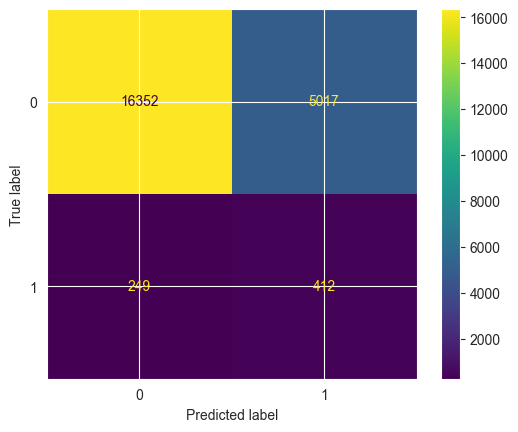

In [33]:
y_val_pred_prob = model_Logit.predict(X_val_logit)

# Calculate ROC curve from validation set
fpr, tpr, thresholds = roc_curve(y_val, y_val_pred_prob)
gmeans = np.sqrt(tpr * (1 - fpr))

# Locate the index of the largest G-mean
ix = np.argmax(gmeans)

# The optimal cutoff is the threshold with the largest G-mean
optimal_cutoff_Logit = thresholds[ix]
print('Optimal Cut-off:', optimal_cutoff_Logit)

# Convert probabilities to binary outcome using the optimal cutoff
y_train_pred_optimal = [1 if prob > optimal_cutoff_Logit else 0 for prob in model_Logit.predict(X_train_logit)]
y_val_pred_optimal = [1 if prob > optimal_cutoff_Logit else 0 for prob in y_val_pred_prob]
y_test_pred_optimal = [1 if prob > optimal_cutoff_Logit else 0 for prob in model_Logit.predict(X_test_logit)]

# Evaluate the model using the simple evaluation function
print("Train set Logit:")
evaluate_predictions(y_train, y_train_pred_optimal)


Validation set Logit:
Balanced Accuracy: 0.7263

Confusion Matrix:
[[5498 1615]
 [  74  157]]

Classification Report:
              precision    recall  f1-score   support

         0.0       0.99      0.77      0.87      7113
         1.0       0.09      0.68      0.16       231

    accuracy                           0.77      7344
   macro avg       0.54      0.73      0.51      7344
weighted avg       0.96      0.77      0.84      7344


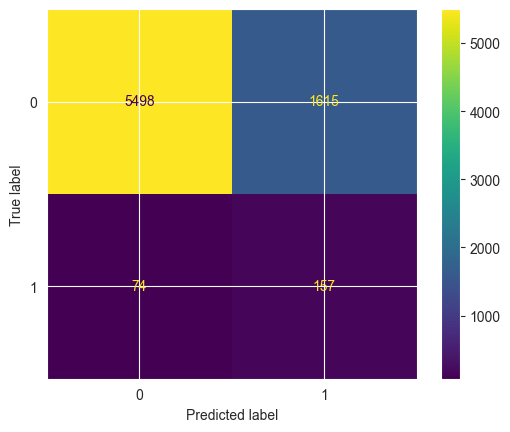

In [34]:
# Evaluate on validation set
print("Validation set Logit:")
evaluate_predictions(y_val, y_val_pred_optimal)

Test set Logit:
Balanced Accuracy: 0.7015

Confusion Matrix:
[[5466 1643]
 [  86  149]]

Classification Report:
              precision    recall  f1-score   support

         0.0       0.98      0.77      0.86      7109
         1.0       0.08      0.63      0.15       235

    accuracy                           0.76      7344
   macro avg       0.53      0.70      0.51      7344
weighted avg       0.96      0.76      0.84      7344


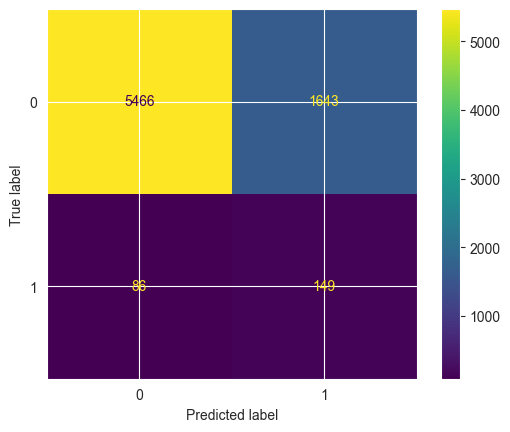

In [35]:
# Evaluate on test set 
print("Test set Logit:")
evaluate_predictions(y_test, y_test_pred_optimal)

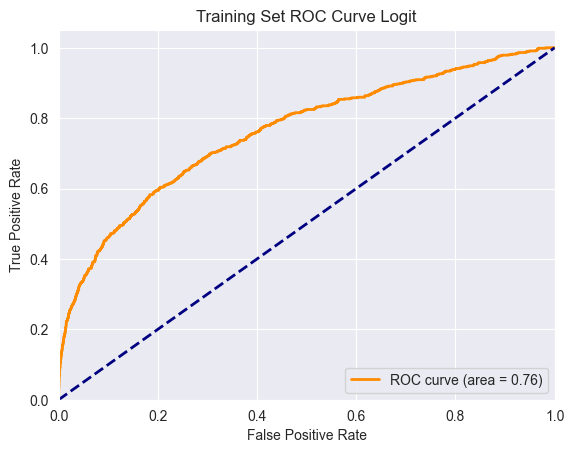

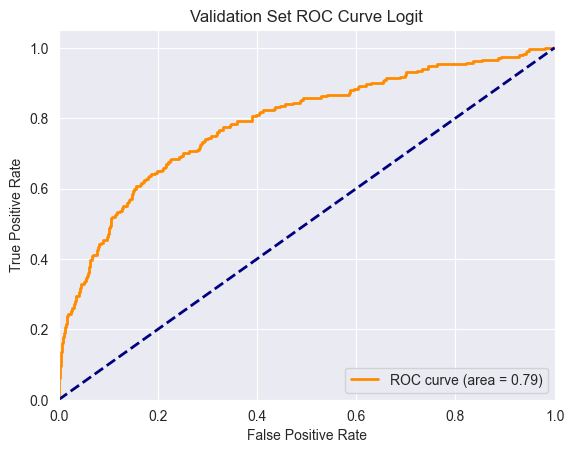

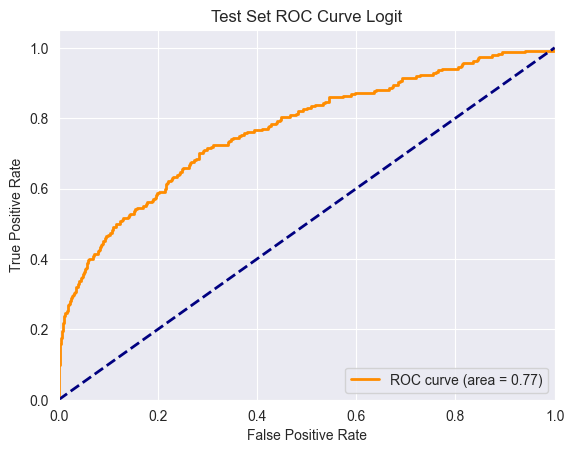

In [36]:
# function to plot ROC curve
def plot_roc_curve(fpr, tpr, title='ROC Curve'):
    roc_auc = auc(fpr, tpr)
    plt.figure()
    lw = 2
    plt.plot(fpr, tpr, color='darkorange', lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(title)
    plt.legend(loc="lower right")
    plt.show()

y_train_pred_prob = model_Logit.predict(X_train_logit)
fpr_train, tpr_train, _ = roc_curve(y_train.astype(int).values, y_train_pred_prob)
plot_roc_curve(fpr_train, tpr_train, 'Training Set ROC Curve Logit')

y_val_pred_prob = model_Logit.predict(X_val_logit)
fpr_val, tpr_val, _ = roc_curve(y_val.astype(int).values, y_val_pred_prob)
plot_roc_curve(fpr_val, tpr_val, 'Validation Set ROC Curve Logit')

y_test_pred_prob = model_Logit.predict(X_test_logit)
fpr_test, tpr_test, _ = roc_curve(y_test.astype(int).values, y_test_pred_prob)
plot_roc_curve(fpr_test, tpr_test, 'Test Set ROC Curve Logit')


For logistic regression, we have achieved the following results:
AUC for test sample of 0.77 (test sample from train dataset) accuracy of 0.77 and balanced accuracy of 0.7 as we decided to use G-mean as a metric.
F1 score, as well as precision and recall are provided in table above. 

Data set provided by ING will be used in last section of the analysis to compare the results of logistic regression with ensemble of (XGBoost and Neural Network models).

## 1.2 
Traditional models like logistic regression, while useful, often struggle to capture the full complexity and nuances present in modern credit datasets. This is where machine learning models like XGBoost and neural networks can shine. In this section, we will train and evaluate both a XGBoost model and a neural network model on the same dataset and compare their performance to the logistic regression model. As our final model we will use an ensemble of the three models to get the best of all worlds. 

#### XGBoost 
XGBoost, short for eXtreme Gradient Boosting, is a highly efficient and scalable implementation of gradient boosting. It operates by constructing an ensemble of decision trees in a sequential manner, with each tree being built to address and correct the mistakes of its predecessors. To enhance the performance of an XGBoost model, hyperparameter tuning is crucial. This is where Optuna comes into play. Optuna is an open-source optimization framework designed to automate the process of finding the best hyperparameters for machine learning models. It efficiently searches the hyperparameter space using Bayesian optimization, gradient-based optimization, or evolutionary algorithms, significantly reducing the time and effort required for manual tuning. In addition to model and hyperparameter optimization, handling imbalanced datasets is another critical aspect of building effective machine learning models. This is particularly important in classification tasks where the distribution of classes is skewed. To address this, Synthetic Minority Over-sampling Technique (SMOTE) is employed. This oversampling technique helps to improve model performance, especially for minority classes, by providing a more balanced dataset for training. It is worth noting that data standardization is not a prerequisite as decision trees is the building blocks of XGBoost. 

In [37]:
# XGB - same dataset as before
X_train_XGB = X_train
X_val_XGB = X_val
X_test_XGB = X_test
y_train_XGB = y_train
y_val_XGB = y_val
y_test_XGB = y_test

In [38]:
%%capture
# Apply SMOTE to oversample the minority class in the training dataset
smote = SMOTE(random_state=1234)
X_train_XGB_resampled, y_train_XGB_resampled = smote.fit_resample(X_train_XGB, y_train_XGB)

def objective(trial):
    param = {
        'objective': 'binary:logistic',
        'use_label_encoder': False,
        'eval_metric': 'auc',
        'n_estimators': trial.suggest_int('n_estimators', 25, 1000),
        'learning_rate': trial.suggest_float('learning_rate', 0.00001, 0.05),
        'max_depth': trial.suggest_int('max_depth', 3, 100),
        'min_child_weight': trial.suggest_int('min_child_weight', 20, 1000),
        'subsample': trial.suggest_float('subsample', 0.6, 0.95),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.6, 0.95),
        'lambda': trial.suggest_float('lambda', 1e-2, 10.0, log=True),
        'alpha': trial.suggest_float('alpha', 1e-2, 10.0, log=True),
    }

    model = XGBClassifier(**{k: v for k, v in param.items() if k != 'early_stopping_rounds'})
    model.set_params(**{'early_stopping_rounds': 100})
    model.fit(X_train_XGB_resampled, y_train_XGB_resampled, eval_set=[(X_val_XGB, y_val_XGB)], verbose=False)
    
    preds_proba = model.predict_proba(X_val_XGB)[:, 1]
    auc_score = roc_auc_score(y_val_XGB, preds_proba)
    
    return auc_score


In [39]:
%%capture
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=50)

[I 2024-03-29 21:01:34,878] A new study created in memory with name: no-name-94154898-c6ea-4393-8f3d-c294756394a3
[I 2024-03-29 21:01:41,613] Trial 0 finished with value: 0.6601485116879464 and parameters: {'n_estimators': 902, 'learning_rate': 0.04157867283088888, 'max_depth': 52, 'min_child_weight': 977, 'subsample': 0.8470777252519255, 'colsample_bytree': 0.6148895237160679, 'lambda': 0.0908953916650883, 'alpha': 0.09289978981858014}. Best is trial 0 with value: 0.6601485116879464.
[I 2024-03-29 21:01:48,004] Trial 1 finished with value: 0.6775929445689041 and parameters: {'n_estimators': 290, 'learning_rate': 0.013323677315504942, 'max_depth': 77, 'min_child_weight': 190, 'subsample': 0.7889481761866852, 'colsample_bytree': 0.8498094800989715, 'lambda': 0.03373928771389568, 'alpha': 2.57662279733336}. Best is trial 1 with value: 0.6775929445689041.
[I 2024-03-29 21:02:00,225] Trial 2 finished with value: 0.6870451821949081 and parameters: {'n_estimators': 620, 'learning_rate': 0.02

In [40]:
print('Best trial:', study.best_trial.params)

Best trial: {'n_estimators': 601, 'learning_rate': 0.02724568547393521, 'max_depth': 96, 'min_child_weight': 25, 'subsample': 0.6046184938132316, 'colsample_bytree': 0.6794698121881011, 'lambda': 0.3301739526398115, 'alpha': 9.989504027191586}


In [41]:
%%capture
model_XGB = XGBClassifier(**study.best_trial.params)
model_XGB.fit(X_train_XGB_resampled, y_train_XGB_resampled, eval_set=[(X_val, y_val)], verbose=False)

Balanced accuracy: 0.577950036363854
Accuracy         : 0.9556100217864923
Train set XGB:
Balanced Accuracy: 0.6242

Confusion Matrix:
[[21086   283]
 [  488   173]]

Classification Report:
              precision    recall  f1-score   support

         0.0       0.98      0.99      0.98     21369
         1.0       0.38      0.26      0.31       661

    accuracy                           0.97     22030
   macro avg       0.68      0.62      0.65     22030
weighted avg       0.96      0.97      0.96     22030

Validation set XGB:
Balanced Accuracy: 0.5731

Confusion Matrix:
[[6983  130]
 [ 193   38]]

Classification Report:
              precision    recall  f1-score   support

         0.0       0.97      0.98      0.98      7113
         1.0       0.23      0.16      0.19       231

    accuracy                           0.96      7344
   macro avg       0.60      0.57      0.58      7344
weighted avg       0.95      0.96      0.95      7344

Test set XGB:
Balanced Accuracy: 0.5780


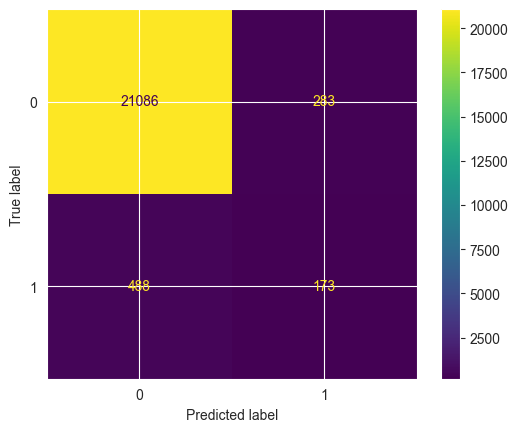

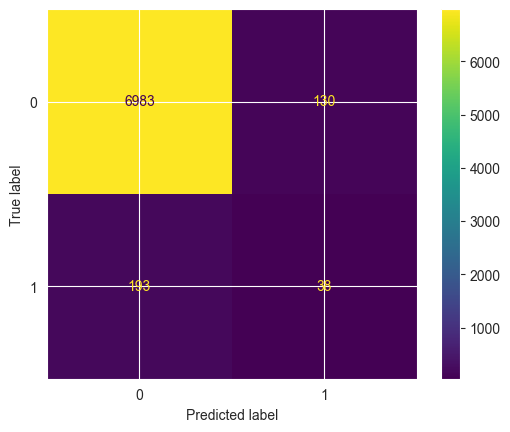

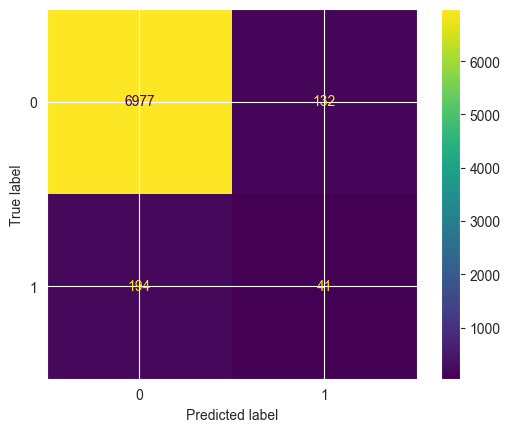

In [42]:
# Evaluate the model on the test set
predictions = model_XGB.predict(X_test_XGB)
print(f"Balanced accuracy: {balanced_accuracy_score(y_test_XGB, predictions)}")
print(f"Accuracy         : {accuracy_score(y_test_XGB, predictions)}")

# Evaluate the model using the simple evaluation function
print("Train set XGB:")
evaluate_predictions(y_train_XGB, model_XGB.predict(X_train_XGB))
print("Validation set XGB:")
evaluate_predictions(y_val_XGB, model_XGB.predict(X_val_XGB))
print("Test set XGB:")
evaluate_predictions(y_test_XGB, predictions)


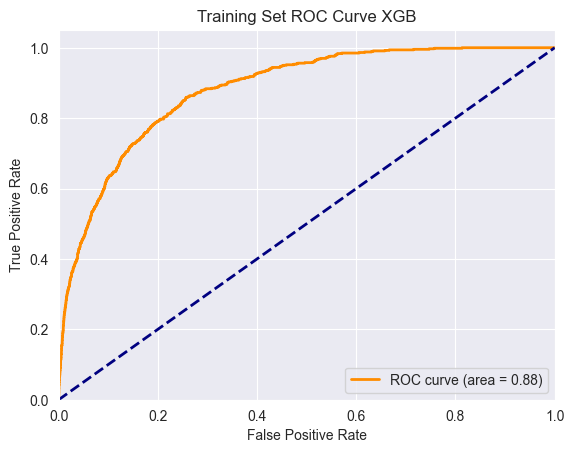

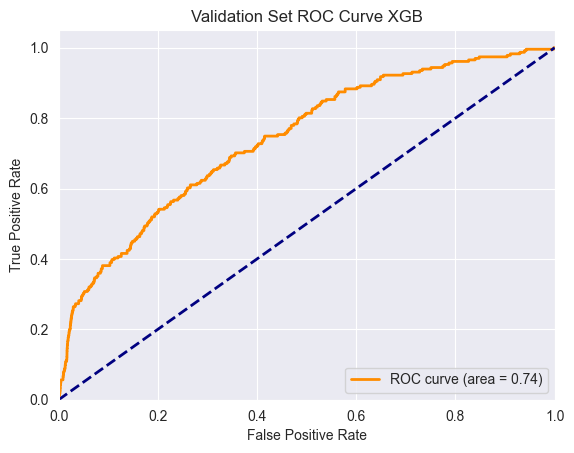

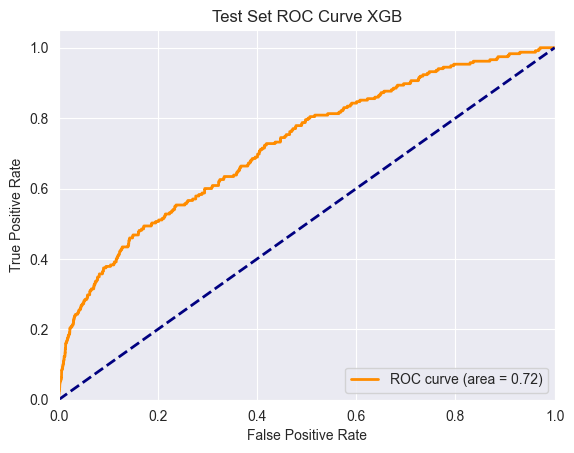

In [43]:
y_train_pred_prob =  model_XGB.predict_proba(X_train_XGB)[:, 1]
fpr_train, tpr_train, _ = roc_curve(y_train.astype(int).values, y_train_pred_prob)
plot_roc_curve(fpr_train, tpr_train, 'Training Set ROC Curve XGB')

y_val_pred_prob = model_XGB.predict_proba(X_val_XGB)[:, 1]
fpr_val, tpr_val, _ = roc_curve(y_val.astype(int).values, y_val_pred_prob)
plot_roc_curve(fpr_val, tpr_val, 'Validation Set ROC Curve XGB')

y_test_pred_prob = model_XGB.predict_proba(X_test_XGB)[:, 1]
fpr_test, tpr_test, _ = roc_curve(y_test.astype(int).values, y_test_pred_prob)
plot_roc_curve(fpr_test, tpr_test, 'Test Set ROC Curve XGB')

## Neural network 

In this section, we will train a neural network model using PyTorch. We will use the same dataset as before and use the same train-test split. We will use 2 layers 256, 128 and output layer. We also added dropout_rate of 0.15, learning rate of 0.002 that is decaying multiplicatively by 0.5 every 10 epochs and weight decay which is L2 regularization of 0.000001. We will use the BCEWithLogitsLoss as the loss function and Adam as the optimizer. We will also use the class weights to handle the class imbalance. We will train the model for 70 epochs and evaluate it on the validation set. 

Which is not shown in the code for simplicity is random search on much wider range of hyperparameters, that was computed to minimize loss on validation set. We provided only the final hyperparameters below.

In [44]:
# Neural network
X_train_NN = X_train
X_val_NN = X_val
X_test_NN = X_test
y_train_NN = y_train
y_val_NN = y_val
y_test_NN = y_test

In [45]:
scaler = StandardScaler()
X_train_NN = scaler.fit_transform(X_train_NN)
X_val_NN = scaler.transform(X_val_NN)
X_test_NN = scaler.transform(X_test_NN)

In [46]:
X_train_tensor = torch.tensor(X_train_NN, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train_NN.to_numpy(), dtype=torch.float32).unsqueeze(1)
X_val_tensor = torch.tensor(X_val_NN, dtype=torch.float32)
y_val_tensor = torch.tensor(y_val_NN.to_numpy(), dtype=torch.float32).unsqueeze(1)
X_test_tensor = torch.tensor(X_test_NN, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test_NN.to_numpy(), dtype=torch.float32).unsqueeze(1)


In [47]:
class BinaryClassificationNN(nn.Module):
    def __init__(self, input_size, dropout_rate=0.15):
        super(BinaryClassificationNN, self).__init__()
        self.layer1 = nn.Linear(input_size, 256)
        self.relu1 = nn.ReLU()
        self.dropout1 = nn.Dropout(dropout_rate)
        self.layer2 = nn.Linear(256, 128)
        self.relu2 = nn.ReLU()
        self.dropout2 = nn.Dropout(dropout_rate)
        self.output_layer = nn.Linear(128, 1)

    def forward(self, x):
        x = self.dropout1(self.relu1(self.layer1(x)))
        x = self.dropout2(self.relu2(self.layer2(x)))
        x = self.output_layer(x)
        return x
    
classes = np.unique(y_train_tensor.numpy())
class_weights = compute_class_weight(class_weight='balanced', classes=classes, y=y_train_tensor.numpy().flatten())
class_weights_tensor = torch.tensor(class_weights[1], dtype=torch.float32)

input_size = X_train_NN.shape[1]
model_NN = BinaryClassificationNN(input_size)
criterion = nn.BCEWithLogitsLoss(pos_weight=class_weights_tensor)
optimizer = optim.Adam(model_NN.parameters(), lr=0.002, weight_decay=0.000001)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.5)

num_epochs = 70

for epoch in range(num_epochs):
    # Forward pass
    outputs = model_NN(X_train_tensor)
    loss = criterion(outputs, y_train_tensor)

    # Backward and optimize
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    # Step the scheduler
    scheduler.step()

    if (epoch+1) % 10 == 0:  # Print loss every 10 epochs
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')

# Evaluate the model on the validation set
with torch.no_grad():
    val_outputs = model_NN(X_val_tensor)
    val_loss = criterion(val_outputs, y_val_tensor)
    val_predictions = torch.sigmoid(val_outputs)
    predicted_classes = (val_predictions >= 0.5).float()
    # Calculate AUC
    auc_score = roc_auc_score(y_val_tensor.numpy(), val_predictions.numpy())
    print(f'Validation Loss: {val_loss.item():.4f}, AUC: {auc_score:.4f}')


Epoch [10/70], Loss: 0.7828
Epoch [20/70], Loss: 0.7579
Epoch [30/70], Loss: 0.7468
Epoch [40/70], Loss: 0.7376
Epoch [50/70], Loss: 0.7336
Epoch [60/70], Loss: 0.7332
Epoch [70/70], Loss: 0.7314
Validation Loss: 0.7898, AUC: 0.7687


Training Set NN evaluation:
Balanced Accuracy: 0.6933

Confusion Matrix:
[[19674  1695]
 [  353   308]]

Classification Report:
              precision    recall  f1-score   support

         0.0       0.98      0.92      0.95     21369
         1.0       0.15      0.47      0.23       661

    accuracy                           0.91     22030
   macro avg       0.57      0.69      0.59     22030
weighted avg       0.96      0.91      0.93     22030


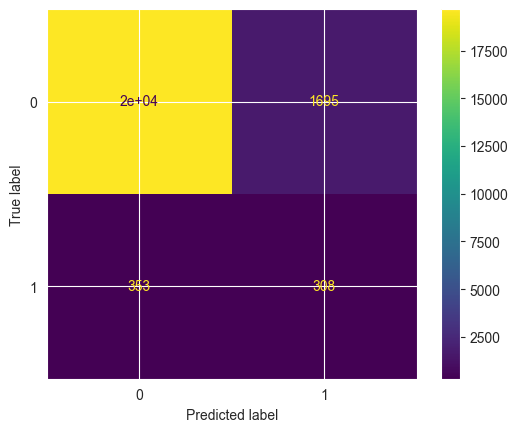

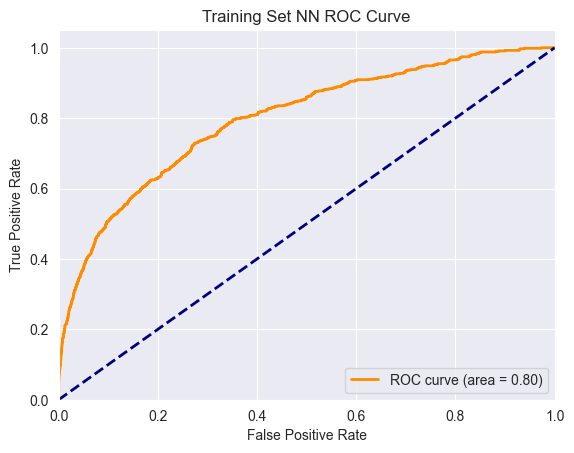

Validation Set NN evaluation:
Balanced Accuracy: 0.6690

Confusion Matrix:
[[6530  583]
 [ 134   97]]

Classification Report:
              precision    recall  f1-score   support

         0.0       0.98      0.92      0.95      7113
         1.0       0.14      0.42      0.21       231

    accuracy                           0.90      7344
   macro avg       0.56      0.67      0.58      7344
weighted avg       0.95      0.90      0.92      7344


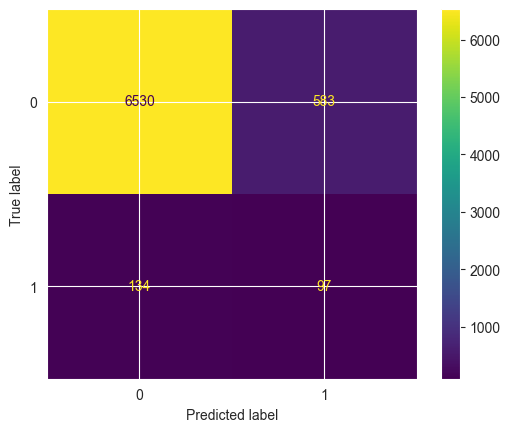

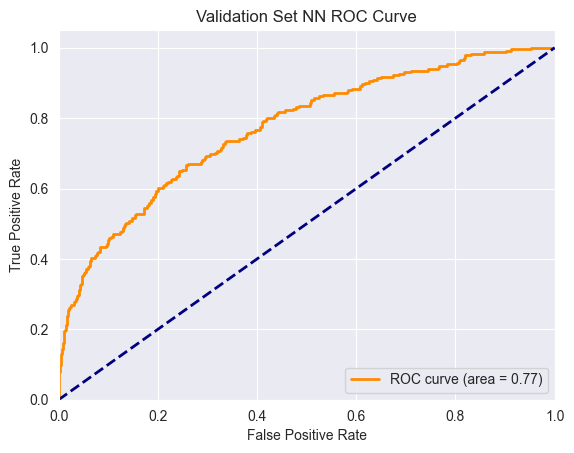

Test Set NN evaluation:
Balanced Accuracy: 0.6698

Confusion Matrix:
[[6528  581]
 [ 136   99]]

Classification Report:
              precision    recall  f1-score   support

         0.0       0.98      0.92      0.95      7109
         1.0       0.15      0.42      0.22       235

    accuracy                           0.90      7344
   macro avg       0.56      0.67      0.58      7344
weighted avg       0.95      0.90      0.92      7344


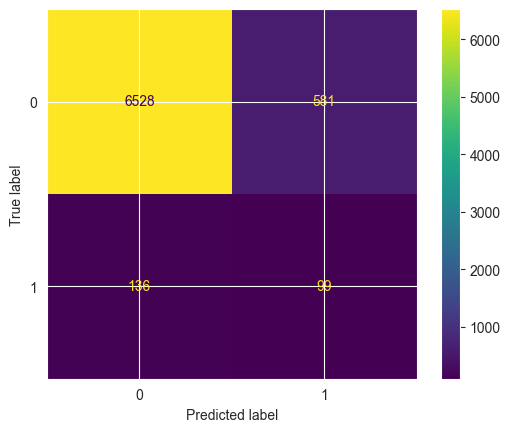

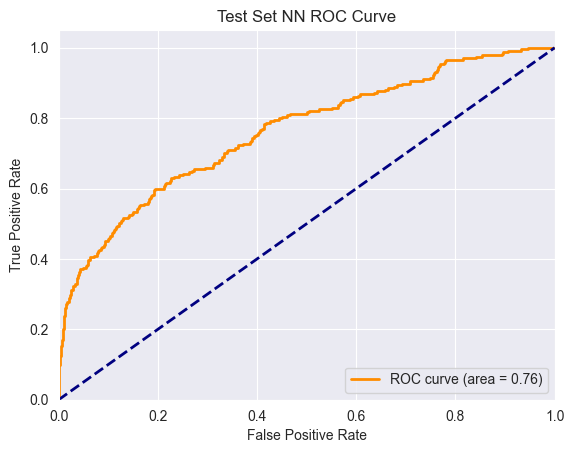

In [48]:
def logits_to_binary_predictions(logits, threshold=0.5):
    probabilities = torch.sigmoid(logits)
    return (probabilities >= threshold).int()

@torch.no_grad()
def evaluate_and_plot(model, X_tensor, y_true_tensor, dataset_name='Dataset'):
    # Get the logits from your model
    logits = model(X_tensor)
    
    # Convert logits to binary predictions and probabilities
    predictions = logits_to_binary_predictions(logits, threshold=0.5).numpy().squeeze()
    probabilities = torch.sigmoid(logits).numpy().squeeze()
    
    # True labels
    y_true = y_true_tensor.numpy()
    
    # Evaluate predictions using your existing function
    print(f"{dataset_name} evaluation:")
    evaluate_predictions(y_true, predictions)
    
    # Compute ROC curve and ROC area
    fpr, tpr, _ = roc_curve(y_true, probabilities)
    plot_roc_curve(fpr, tpr, title=f'{dataset_name} ROC Curve')

# Now, call this function for each of your datasets: training, validation, and test sets.
evaluate_and_plot(model_NN, X_train_tensor, y_train_tensor, 'Training Set NN')
evaluate_and_plot(model_NN, X_val_tensor, y_val_tensor, 'Validation Set NN')
evaluate_and_plot(model_NN, X_test_tensor, y_test_tensor, 'Test Set NN')

In [49]:
test_probabilities = torch.sigmoid(model_NN(X_test_tensor)).detach().numpy().squeeze()
print(test_probabilities.min(), test_probabilities.max())
test_probabilities


1.3382951e-05 0.9996661


array([0.03076419, 0.34645447, 0.27544516, ..., 0.0668446 , 0.09539779,
       0.2900712 ], dtype=float32)

In [85]:
y_train_logit_prob = model_Logit.predict(X_train_logit)
y_train_XGB_prob = model_XGB.predict_proba(X_train_XGB)[:, 1]
y_train_NN_prob = torch.sigmoid(model_NN(X_train_tensor)).detach().numpy().squeeze()

y_val_logit_prob = model_Logit.predict(X_val_logit)
y_val_XGB_prob = model_XGB.predict_proba(X_val_XGB)[:, 1]
y_val_NN_prob = torch.sigmoid(model_NN(X_val_tensor)).detach().numpy().squeeze()

y_test_logit_prob = model_Logit.predict(X_test_logit)
y_test_XGB_prob = model_XGB.predict_proba(X_test_XGB)[:, 1]
y_test_NN_prob = torch.sigmoid(model_NN(X_test_tensor)).detach().numpy().squeeze()

y_train = y_train.reset_index(drop=True)

In [179]:
from sklearn.neighbors import NearestNeighbors
from sklearn.metrics import roc_auc_score

scaler = StandardScaler()

# Fit on training data and transform it
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

def choose_and_predict_best_model(X_train, X_test, y_train, 
                                  y_train_logit_prob, y_train_XGB_prob, y_train_NN_prob,
                                  y_test_logit_prob, y_test_XGB_prob, y_test_NN_prob, k):

    # Initialize NearestNeighbors
    neighbors = NearestNeighbors(n_neighbors=k)
    neighbors.fit(X_train)
    
    # Store predictions for each test observation
    final_predictions = []
    model_choice_counts = {'Logistic Regression': 0, 'XGBoost': 0, 'Neural Network': 0}
    
    # Iterate over each test observation
    for i, test_instance in enumerate(X_test):
        # Reshape test_instance for compatibility with sklearn
        test_instance = test_instance.reshape(1, -1)
        
        # Find K nearest neighbors
        _, indices = neighbors.kneighbors(test_instance)
        neighbor_indices = indices.flatten()
        
        # Get neighbor labels and probabilities
        neighbor_labels = y_train[neighbor_indices]
        logit_probs = y_train_logit_prob[neighbor_indices]
        xgb_probs = y_train_XGB_prob[neighbor_indices]
        nn_probs = y_train_NN_prob[neighbor_indices]
        
        # Calculate AUC for each model
        auc_scores = {
            'Logistic Regression': roc_auc_score(neighbor_labels, logit_probs),
            'XGBoost': roc_auc_score(neighbor_labels, xgb_probs),
            'Neural Network': roc_auc_score(neighbor_labels, nn_probs)
        }
        
        # Determine the best model
        best_model = max(auc_scores, key=auc_scores.get)
        model_choice_counts[best_model] += 1
        
        # Use the best model to make a prediction for the test instance
        if best_model == 'Logistic Regression':
            final_predictions.append(y_test_logit_prob[i])
        elif best_model == 'XGBoost':
            final_predictions.append(y_test_XGB_prob[i])
        else:  # Neural Network
            final_predictions.append(y_test_NN_prob[i])
    
    # Print model choice counts
    print("Model choice counts:")
    for model, count in model_choice_counts.items():
        print(f"{model}: {count}")
    
    return final_predictions


# Assume X_train, y_train, and X_test are already defined and correctly preprocessed to match your models' inputs.
k = 500  # Choose an appropriate value for k

final_predictions = choose_and_predict_best_model(
    X_train_scaled.to_numpy(),  # Convert X_train to numpy array if it's a DataFrame
    X_test_scaled.to_numpy(),  # Convert X_test to numpy array
    y_train, 
    y_train_logit_prob, y_train_XGB_prob, y_train_NN_prob,
    y_test_logit_prob, y_test_XGB_prob, y_test_NN_prob, k
)

KeyboardInterrupt: 

In [ ]:
final_predictions.mean()

In [ ]:
fpr_test, tpr_test, _ = roc_curve(y_test.astype(int).values, final_predictions)
plot_roc_curve(fpr_test, tpr_test, 'Test Set ROC Curve KNN-ENSEMBLE')

## ENSEMBLE MODEL

For our final proposition of the model we decided to use an ensemble of 2 models as average of probabilities from XGboost model and Neural Network. We calculated best cut off based on validation set and G-means value as mentioned before we don't have information about costs of wrong decisions and missed potential profits.

In [ ]:
# ENSEMBLE MODEL 
# Predictions from each model
y_test_logit_prob = model_Logit.predict(X_test_logit)
y_test_XGB_prob = model_XGB.predict_proba(X_test_XGB)[:, 1]
y_test_NN_prob = torch.sigmoid(model_NN(X_test_tensor)).detach().numpy().squeeze()

ensemble_prob = (y_test_XGB_prob + y_test_NN_prob)/2
print(ensemble_prob)

In [ ]:
# Compute ROC curve and ROC area for the logit model
y_test_pred_prob = model_Logit.predict(X_test_logit)
fpr_test, tpr_test, _ = roc_curve(y_test.astype(int).values, y_test_pred_prob)
plot_roc_curve(fpr_test, tpr_test, 'Test Set ROC Curve logit')

In [ ]:
fpr_test, tpr_test, _ = roc_curve(y_test.astype(int).values, ensemble_prob)
plot_roc_curve(fpr_test, tpr_test, 'Test Set ROC Curve Ensemble')

In [ ]:
# Compute ROC curve and ROC area for the logistic regression model
fpr_logit, tpr_logit, thresholds_logit = roc_curve(y_test.astype(int).values, y_test_pred_prob)
roc_auc_logit = auc(fpr_logit, tpr_logit)

# Compute ROC curve and ROC area for the ensemble model
fpr_ensemble, tpr_ensemble, thresholds_ensemble = roc_curve(y_test.astype(int).values, ensemble_prob)
roc_auc_ensemble = auc(fpr_ensemble, tpr_ensemble)

# Plotting both ROC curves on the same plot
plt.figure(figsize=(10, 8))
plt.plot(fpr_logit, tpr_logit, color='blue', label='Logit ROC curve (area = %0.2f)' % roc_auc_logit)
plt.plot(fpr_ensemble, tpr_ensemble, color='darkorange', label='Ensemble ROC curve (area = %0.2f)' % roc_auc_ensemble)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic Comparison')
plt.legend(loc="lower right")
plt.show()

In [ ]:
# calculate best cut off based on validation set
y_val_XGB_prob = model_XGB.predict_proba(X_val_XGB)[:, 1]
y_val_NN_prob = torch.sigmoid(model_NN(X_val_tensor)).detach().numpy().squeeze()
ensemble_prob_val = (y_val_XGB_prob + y_val_NN_prob)/2
fpr, tpr, thresholds = roc_curve(y_val, ensemble_prob_val)
gmeans = np.sqrt(tpr * (1 - fpr))
ix = np.argmax(gmeans)
optimal_cutoff_ensemble = thresholds[ix]

# Evaluate the ensemble model using the simple evaluation function
ensemble_predictions = (ensemble_prob >= optimal_cutoff_ensemble).astype(int)
print("Test set Ensemble:")
evaluate_predictions(y_test, ensemble_predictions)

Now lets compare results on our test sample seperated from train dataset. For logistic regression we have achieved AUC of 0.77 while for ensemble model we have achieved AUC of 0.78. We can see that ensemble model is slightly better than logistic regression model in this case. For accuracy we have 0.76 for logistic regression and 0.74 for ensemble model. Balanced accuracy is 0.701 for logistic regression and 0.703 for ensemble model. Rest statistics also point out that both models have similar performance. 

now let's analyze the data set provided by ING, in real life we wouldn't have correct predictions for this data set, but we can use it to compare the results of our models.

In [ ]:
## data set provided by ING 
# same transformations as before
test = pd.read_csv('https://files.challengerocket.com/files/lions-den-ing-2024/testing_sample.csv')
df_test = test[test['Application_status'] == 'Approved'].copy()

d1_test = pd.to_datetime(df_test['application_date'].copy(), format='%d%b%Y %H:%M:%S', errors='coerce')
d2_test = pd.to_datetime(df_test['Var13'], format='%d%b%Y', errors='coerce')
df_test[days_from_employment] = (d1_test - d2_test).dt.days

df_test['Var17'].fillna(df_test['Var17'].median(), inplace=True)

for var in fill_with_zero:
    df_test[var].fillna(0, inplace=True)

for var in add_other_category:
    df_test[var].fillna('other', inplace=True)

df_test.drop(columns=not_features + other_to_drop + columns_to_drop, inplace=True)

need_dummies = set(categorical_features) - set(columns_to_drop)

for feature in need_dummies:
    one_hot = pd.get_dummies(df_test[feature], prefix=feature, drop_first=True).astype(int)
    df_test = df_test.drop(feature, axis=1)
    df_test = df_test.join(one_hot)

# Add missing categories to get the same shape 
right_order = X.columns
df_test = df_test.rename(columns={'Var3_3.0':'Var3_3', 'Var3_2.0':'Var3_2'})
df_test['Var3_Direct'] = 0
df_test['Var3_Online'] = 0

X_test_2 = df_test.drop(columns=['target'])[right_order]
Y_test_2 = df_test['target']

X_test_logit_2 = scaler.fit_transform(X_test_2)

test_predictions_NN = torch.sigmoid(model_NN(torch.tensor(X_test_logit_2, dtype=torch.float32))).detach().numpy().squeeze()
test_predictions_XGB = model_XGB.predict_proba(X_test_2)[:, 1]
ensemble_prob_test = (test_predictions_NN + test_predictions_XGB)/2
ensemble_predictions_test = (ensemble_prob_test >= optimal_cutoff_ensemble).astype(int)
print("Test set ensemble ING:")
evaluate_predictions(ensemble_predictions_test, Y_test_2)

# roc curve
fpr_test, tpr_test, _ = roc_curve(Y_test_2.astype(int).values, ensemble_prob_test)
plot_roc_curve(fpr_test, tpr_test, 'ING Test Set ROC Curve Ensemble')

# compare with logit model
test_probabilities = model_Logit.predict(X_test_logit_2)
logit_predictions_test = (test_probabilities >= optimal_cutoff_Logit).astype(int)

print("Test set Logit ING:")
evaluate_predictions(logit_predictions_test, Y_test_2)
fpr_test, tpr_test, _ = roc_curve(Y_test_2.astype(int).values, test_probabilities)
plot_roc_curve(fpr_test, tpr_test, 'ING Test Set ROC Curve Logit')

# Compute ROC curve and ROC area for the logistic regression model
fpr_logit, tpr_logit, thresholds_logit = roc_curve(Y_test_2.astype(int).values, test_probabilities)
roc_auc_logit = auc(fpr_logit, tpr_logit)

# Compute ROC curve and ROC area for the ensemble model
fpr_ensemble, tpr_ensemble, thresholds_ensemble = roc_curve(Y_test_2.astype(int).values, ensemble_prob_test)
roc_auc_ensemble = auc(fpr_ensemble, tpr_ensemble)

# Plotting both ROC curves on the same plot
plt.figure(figsize=(10, 8))
plt.plot(fpr_logit, tpr_logit, color='blue', label='Logit ROC curve (area = %0.2f)' % roc_auc_logit)
plt.plot(fpr_ensemble, tpr_ensemble, color='darkorange', label='Ensemble ROC curve (area = %0.2f)' % roc_auc_ensemble)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic Comparison')
plt.legend(loc="lower right")
plt.show()

### Final summary for 1.2 task

Our main statistic to maximise was AUC. As accuracy and balanced accuracy can be changed by setting a different cut-off point, for both models G-means statistic was used. AUC on ING test sample for logistic regression was 0.71 while ensemble model achieved 0.74 which is a significant improvement. For Accuracy Logit has 0.71 while ensemble 0.75 and for balanced accuracy Logit has 0.52 while ensemble 0.53. As we can see Ensemble model outperformed logistic regression model in all metrics (as well for F1, precision and recall). However, it is worth to point out that with more complicated models like ensemble of different so called "black box" models, it is harder to interpret the results and explain the model to the client. One of the biggest challenges with ensemble models is their lack of interpretability compared to simpler models like logistic regression. In the banking sector, where regulatory compliance and the ability to explain decisions to customers are paramount, the "black box" nature of ensemble models can be a significant drawback. We would need to perform very hard computations with methods like SHAP or LIME to explain the results. Which we haven't done in this analysis due to the time constraints. In real life this would be hard to implement in banking sector as validation of the model would be hard to perform. 

Jedrzej Maskiewicz, Adam Ginna, Wiktor Morawski, Grzegorz Szot

 